# MACHINE LEARNING PROJECT
## Housing Prices
https://www.dropbox.com/s/zxv6ujxl8kmijfb/cal-housing.csv?dl=0

Implement from scratch the ridge regression algorithm for regression with square loss (lecture notes on “Linear prediction”). It is OK to use libraries for linear algebra and basic data manipulation (e.g., Numpy and Pandas). Apply the algorithm to the prediction of the label medianHouseValue in this dataset. Study the dependence of the cross-validated risk estimate on the parameter alpha of ridge regression. Try using PCA to improve the risk estimate. Optionally, use nested cross-validated risk estimates to remove the need of choosing the parameter.

To do list:
- Check ridge
- Further exploration



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
import seaborn as sns
import matplotlib.transforms as transforms
from scipy.stats import norm
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn import decomposition

In [2]:
orig_df = pd.read_csv("cal-housing.csv")

In [3]:
orig_df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

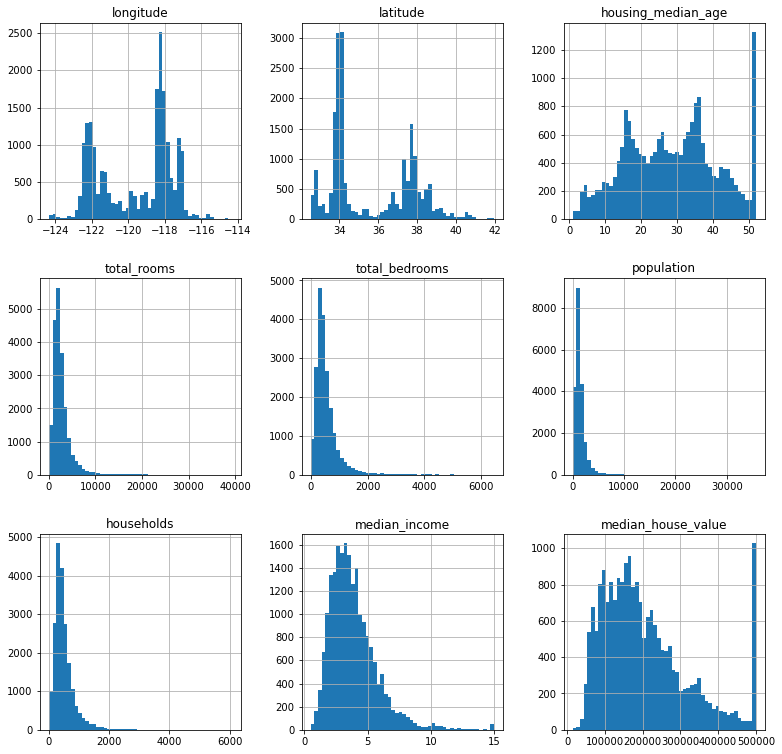

In [4]:
orig_df.hist(bins=50, figsize=(13, 13))

### Missing Values

In [5]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


*Total_bedrooms* variable contains 20433 instead of 20640 values: we have 207 missing values.
We can use different techniques to solve this problem: one of those is to replace missing values with the average value of the column.

In [6]:
corr_df = orig_df.copy()

In [7]:
corr_df['total_bedrooms'].fillna(corr_df['total_bedrooms'].mean(), inplace=True)

In [8]:
print(corr_df['total_bedrooms'].mean(), orig_df['total_bedrooms'].mean())

537.8705525375639 537.8705525375618


### Ocean_proximity variable

Between the variables below, we do not see ocean_proximity, because it is categorical. To be used in our model, we need to solve this situation.

In [9]:
corr_df.ocean_proximity.describe()

count         20640
unique            5
top       <1H OCEAN
freq           9136
Name: ocean_proximity, dtype: object

In [10]:
corr_df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Since __ISLAND__ category has such a different numerousness, we decided to remove it from the possible values of the *ocean_proximity* variable.

In [11]:
corr_df = corr_df.loc[corr_df["ocean_proximity"] != "ISLAND"]

In [12]:
labels, uniques = pd.factorize(['<1H OCEAN', 'INLAND', 'NEAR OCEAN','NEAR BAY' ])
labels

array([0, 1, 2, 3], dtype=int64)

In [13]:
ocean_mapper = {
    'NEAR BAY': 0,
    'NEAR OCEAN': 1,
    '<1H OCEAN' : 2,
    'INLAND' : 3
    }

In [14]:
corr_df.replace({'ocean_proximity': ocean_mapper}, inplace=True) 

In [15]:
corr_df.ocean_proximity.value_counts()

2    9136
3    6551
1    2658
0    2290
Name: ocean_proximity, dtype: int64

# Data Exploration

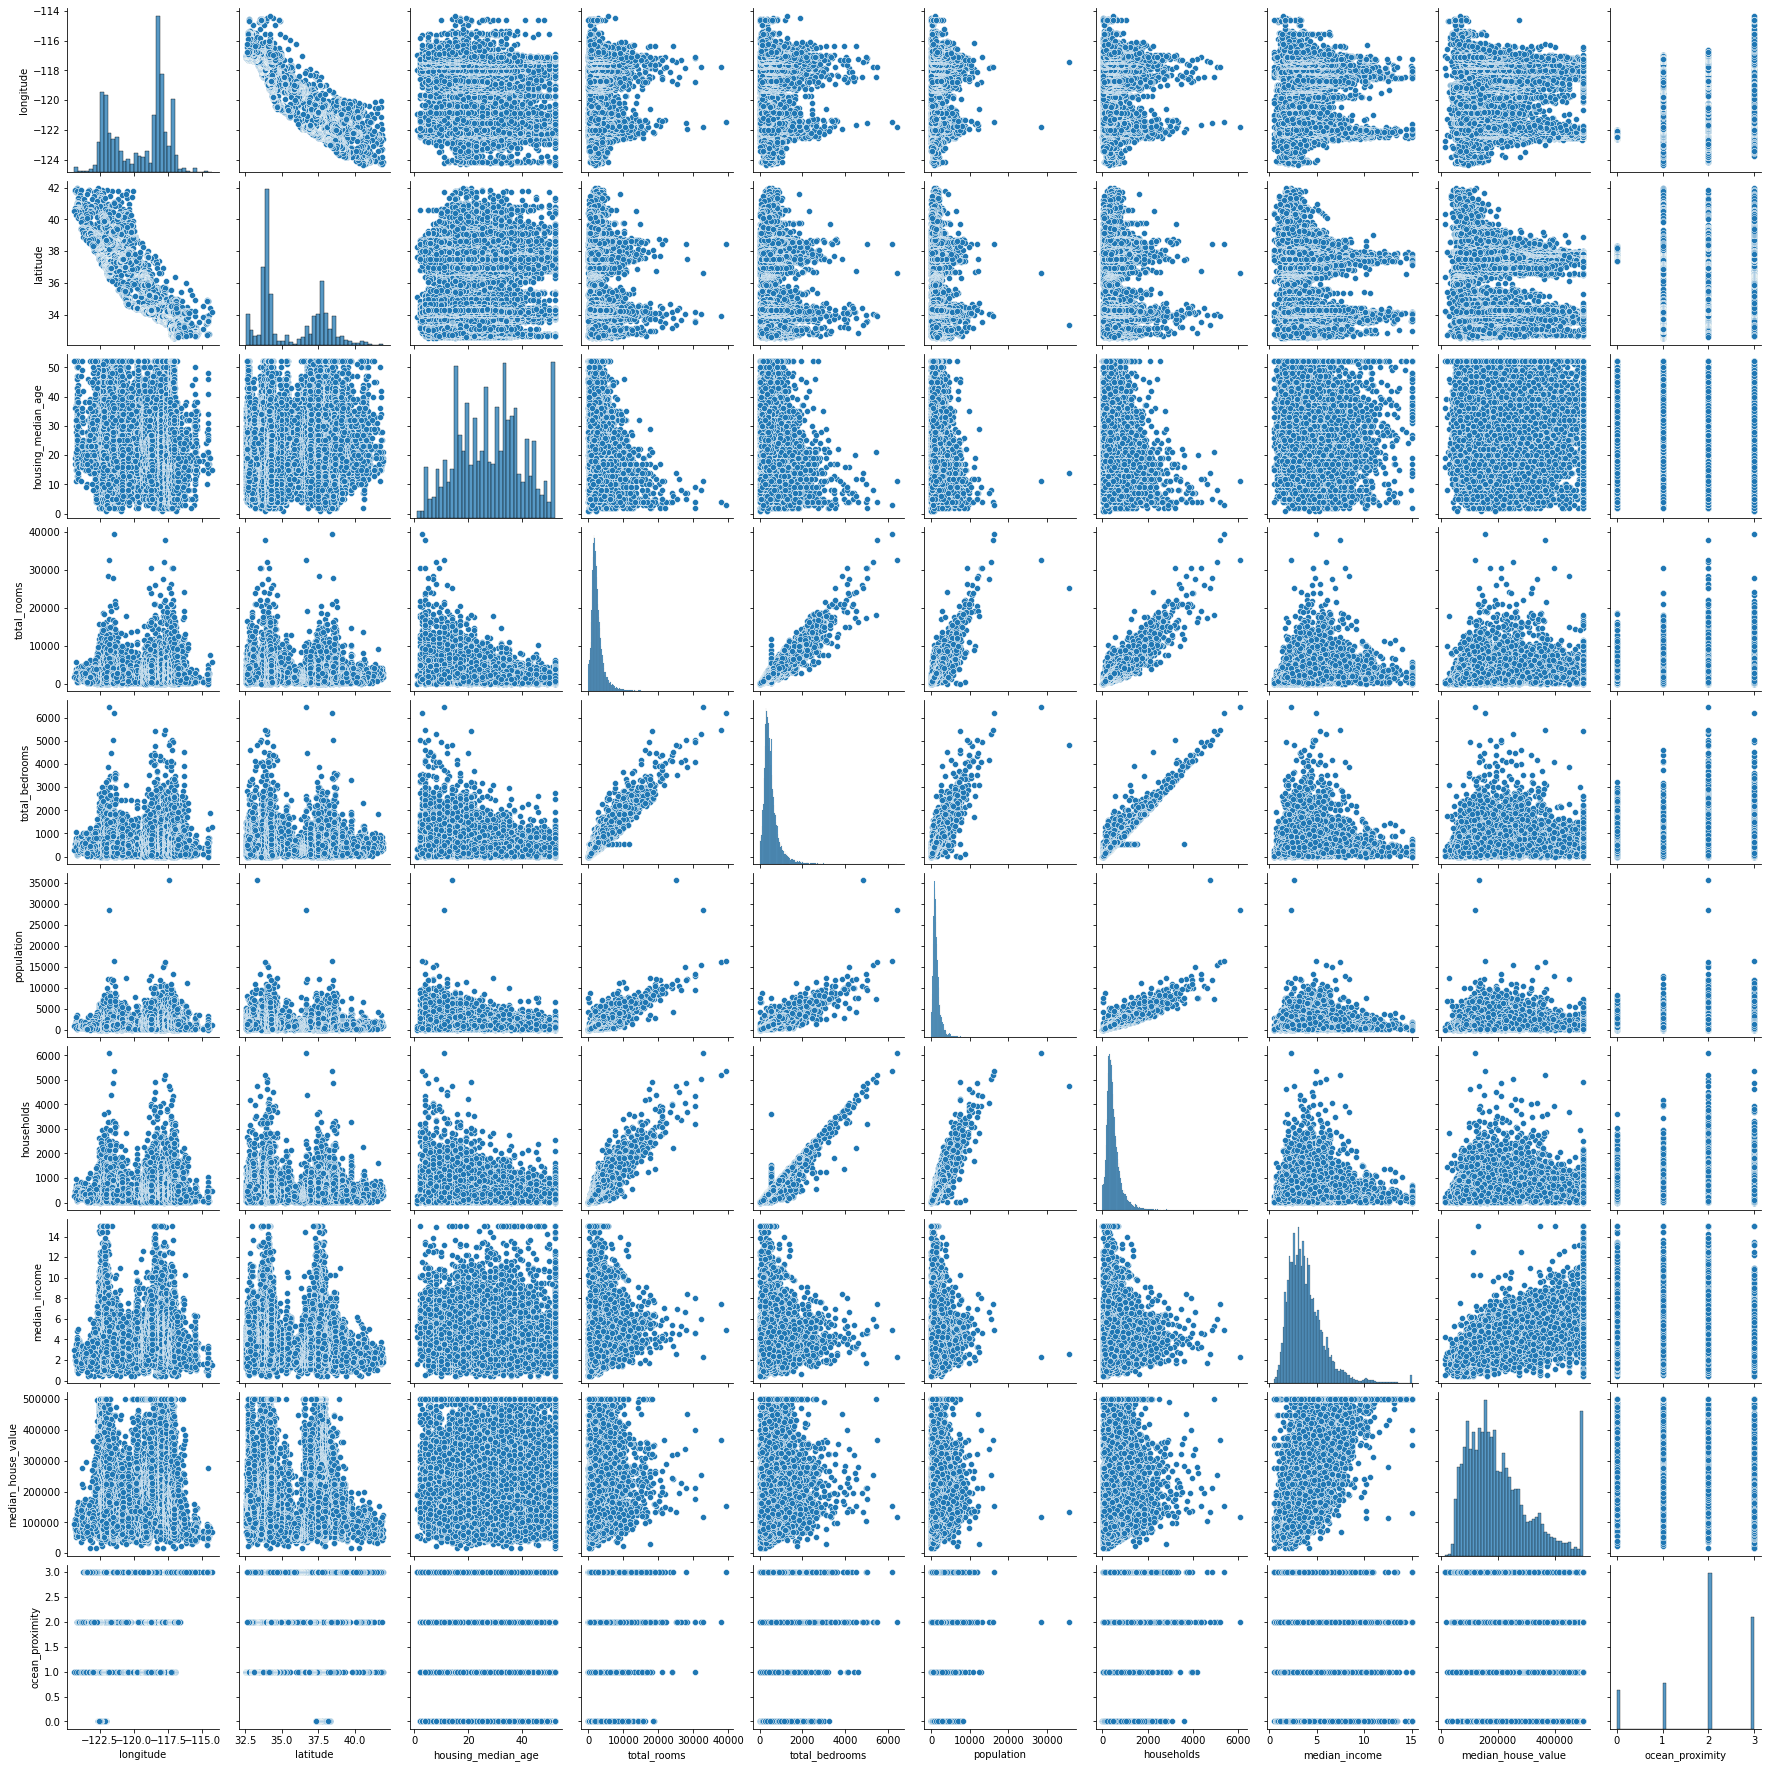

In [16]:
sns.pairplot(corr_df)

In [17]:
corr_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20635.000000,20635.000000,20635.000000,20635.000000,20635.000000,20635.000000,20635.000000,20635.000000,20635.000000,20635.000000
mean,-119.569999,35.632412,28.636152,2636.020208,537.899016,1425.660286,499.593700,3.870944,206813.756288,1.966707
std,2.003685,2.135918,12.583924,2181.794772,419.306772,1132.530137,382.357072,1.899961,115372.499511,0.942932
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000
25%,-121.800000,33.930000,18.000000,1448.000000,297.000000,787.000000,280.000000,2.563100,119600.000000,2.000000
50%,-118.500000,34.260000,29.000000,2127.000000,438.000000,1166.000000,409.000000,3.535200,179700.000000,2.000000
75%,-118.010000,37.710000,37.000000,3148.000000,644.000000,1725.000000,605.000000,4.743700,264700.000000,3.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,3.000000


<Figure size 432x288 with 0 Axes>

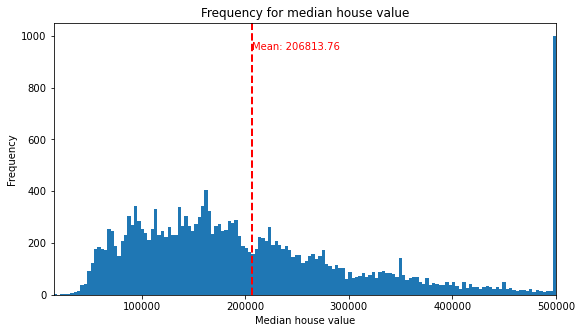

In [18]:
# Variable HOUSE VALUE
fig = plt.figure()
plt.figure(figsize=(9,5))
plt.hist(corr_df.median_house_value , bins= 150)
plt.xlim(15000,500001)
plt.title('Frequency for median house value')
plt.xlabel("Median house value")
plt.ylabel("Frequency")
#plt.grid(True)
plt.axvline(corr_df.median_house_value.mean(), color='red', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(corr_df.median_house_value.mean(), max_ylim*0.9, 'Mean: {:.2f}'.format(corr_df.median_house_value.mean()), color='red')
fig.savefig("images\Frequency for median house value.png")
plt.show()

In [19]:
corr_df.drop(corr_df[corr_df.median_house_value == 500001].index, inplace=True)

<Figure size 432x288 with 0 Axes>

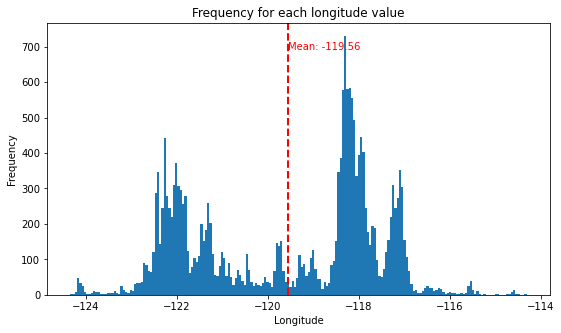

In [20]:
fig = plt.figure()
plt.figure(figsize=(9,5))
plt.hist(corr_df.longitude.values, bins= 200)
plt.title('Frequency for each longitude value')
plt.xlabel("Longitude")
plt.ylabel("Frequency")
#plt.grid(True)
plt.axvline(corr_df.longitude.mean(), color='red', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(corr_df.longitude.mean(), max_ylim*0.9, 'Mean: {:.2f}'.format(corr_df.longitude.mean()), color='red')
fig.savefig("images\Frequency for each longitude value.png")
plt.show()

<Figure size 432x288 with 0 Axes>

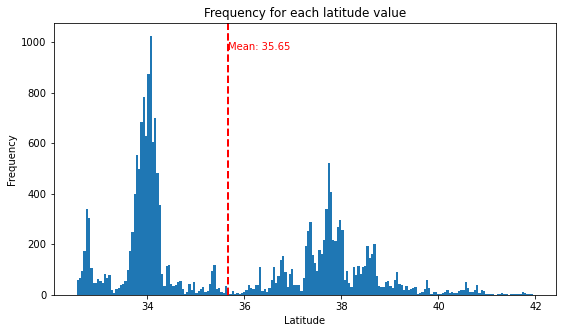

In [21]:
fig = plt.figure()
plt.figure(figsize=(9,5))
plt.hist(corr_df.latitude.values, bins= 200)
plt.title('Frequency for each latitude value')
plt.xlabel("Latitude")
plt.ylabel("Frequency")
#plt.grid(True)
plt.axvline(corr_df.latitude.mean(), color='red', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(corr_df.latitude.mean(), max_ylim*0.9, 'Mean: {:.2f}'.format(corr_df.latitude.mean()), color='red')
fig.savefig("images\Frequency for each latitude value.png")
plt.show()

<Figure size 432x288 with 0 Axes>

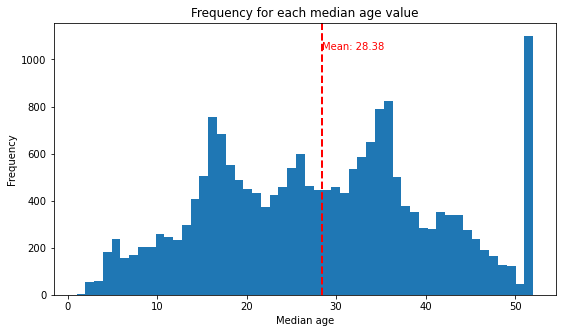

In [22]:
fig = plt.figure()
plt.figure(figsize=(9,5))
plt.hist(corr_df.housing_median_age.values, bins= 52) #has only 52 unique values
plt.title('Frequency for each median age value')
plt.xlabel("Median age")
plt.ylabel("Frequency")
#plt.grid(True)
plt.axvline(corr_df.housing_median_age.mean(), color='red', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(corr_df.housing_median_age.mean(), max_ylim*0.9, 'Mean: {:.2f}'.format(corr_df.housing_median_age.mean()), color='red')
fig.savefig("images\Frequency for each Median age value.png")
plt.show()

In [23]:
corr_df.drop(corr_df[corr_df.housing_median_age == 52].index, inplace=True)

In [24]:
unique_list = []
def unique(list1):    
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
        
unique(corr_df.housing_median_age)
unique_list
len(unique_list)

51

<Figure size 432x288 with 0 Axes>

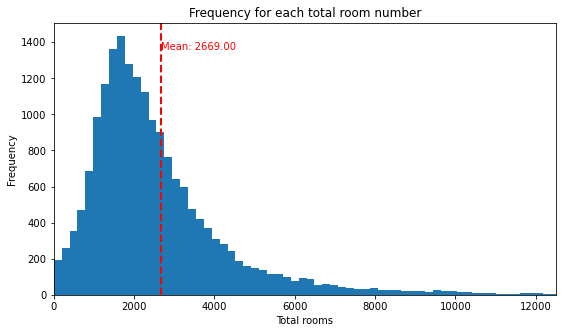

In [25]:
fig = plt.figure()
plt.figure(figsize=(9,5))
plt.hist(corr_df.total_rooms.values, bins= 200)
plt.xlim(0,12500)
plt.title('Frequency for each total room number')
plt.xlabel("Total rooms")
plt.ylabel("Frequency")
#plt.grid(True)
plt.axvline(corr_df.total_rooms.mean(), color='red', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(corr_df.total_rooms.mean(), max_ylim*0.9, 'Mean: {:.2f}'.format(corr_df.total_rooms.mean()), color='red')
fig.savefig("images\Frequency for each total room number.png")
plt.show()

<Figure size 432x288 with 0 Axes>

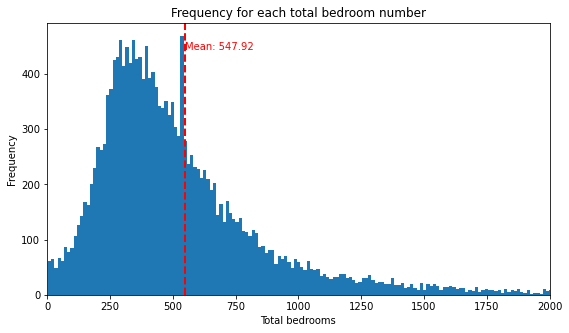

In [26]:
fig = plt.figure()
plt.figure(figsize=(9,5))
plt.hist(corr_df.total_bedrooms.values, bins= 500)
plt.xlim(0,2000)
plt.title('Frequency for each total bedroom number')
plt.xlabel("Total bedrooms")
plt.ylabel("Frequency")
#plt.grid(True)
plt.axvline(corr_df.total_bedrooms.mean(), color='red', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(corr_df.total_bedrooms.mean(), max_ylim*0.9, 'Mean: {:.2f}'.format(corr_df.total_bedrooms.mean()), color='red')
fig.savefig("images\Frequency for each total bedroom number.png")
plt.show()

<Figure size 432x288 with 0 Axes>

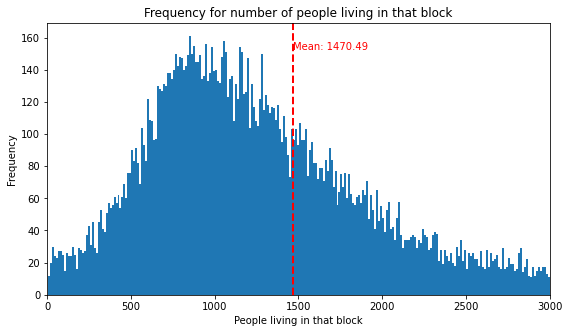

In [27]:
fig = plt.figure()
plt.figure(figsize=(9,5))
plt.hist(corr_df.population.values, bins= 3000)
plt.xlim(0,3000)
plt.title('Frequency for number of people living in that block')
plt.xlabel("People living in that block")
plt.ylabel("Frequency")
#plt.grid(True)
plt.axvline(corr_df.population.mean(), color='red', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(corr_df.population.mean(), max_ylim*0.9, 'Mean: {:.2f}'.format(corr_df.population.mean()), color='red')
fig.savefig("images\Frequency for population.png")
plt.show()

<Figure size 432x288 with 0 Axes>

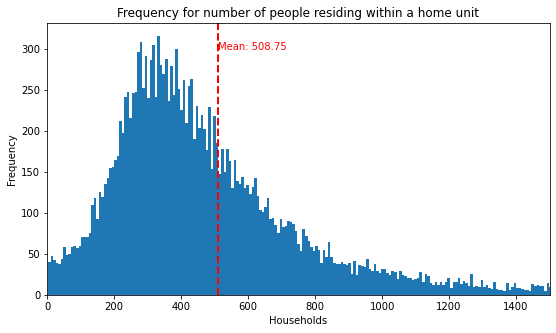

In [28]:
fig = plt.figure()
plt.figure(figsize=(9,5))
plt.hist(corr_df.households.values, bins= 800)
plt.xlim(0,1500)
plt.title('Frequency for number of people residing within a home unit')
plt.xlabel("Households")
plt.ylabel("Frequency")
#plt.grid(True)
plt.axvline(corr_df.households.mean(), color='red', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(corr_df.households.mean(), max_ylim*0.9, 'Mean: {:.2f}'.format(corr_df.households.mean()), color='red')
fig.savefig("images\Frequency for households.png")
plt.show()

<Figure size 432x288 with 0 Axes>

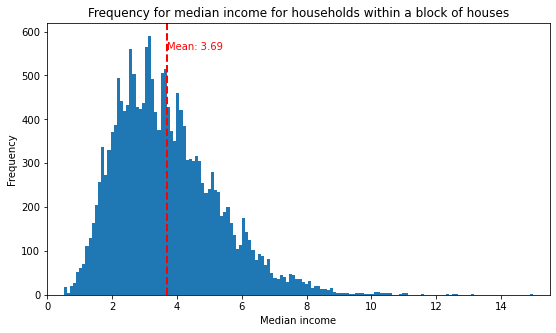

In [29]:
fig = plt.figure()
plt.figure(figsize=(9,5))
plt.hist(corr_df.median_income.values, bins= 150)
plt.xlim(0,15.5)
plt.title('Frequency for median income for households within a block of houses')
plt.xlabel("Median income")
plt.ylabel("Frequency")
#plt.grid(True)
plt.axvline(corr_df.median_income.mean(), color='red', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(corr_df.median_income.mean(), max_ylim*0.9, 'Mean: {:.2f}'.format(corr_df.median_income.mean()), color='red')
fig.savefig("images\Frequency for median income.png")
plt.show()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

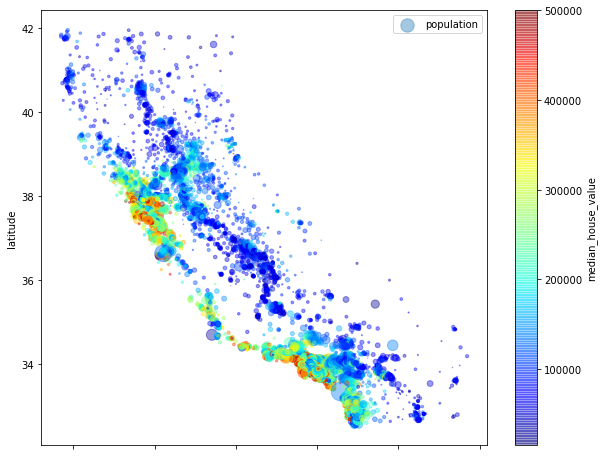

In [30]:
long_lat_value = corr_df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
    s=corr_df['population']/100, label='population', figsize=(10,8), 
    c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
long_lat_value.figure.savefig("images\long_lat_value.png")
long_lat_value

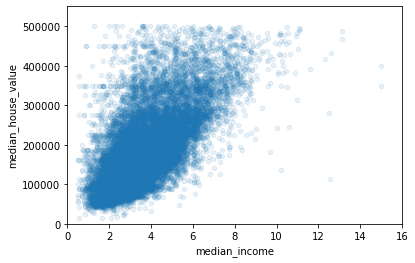

In [31]:
corr_df.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.axis([0, 16, 0, 550000])
plt.show()

Now we look deeply at the distribution of the lables using *distplot()* function by *seaborn*.

C:\Users\marti\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


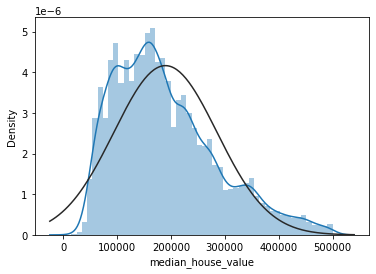

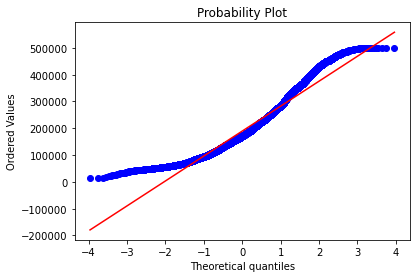

In [32]:
sns.distplot(corr_df['median_house_value'], fit=norm);
fig = plt.figure()
res = stats.probplot(corr_df['median_house_value'], plot=plt)

C:\Users\marti\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


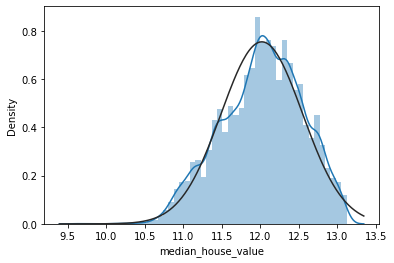

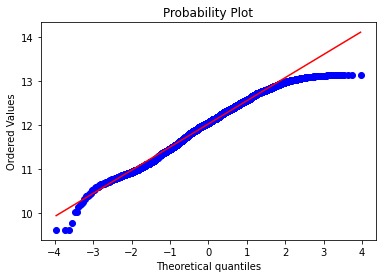

In [33]:
log_house_value = np.log(corr_df['median_house_value'])
sns.distplot(log_house_value, fit=norm);
fig = plt.figure()
res = stats.probplot(log_house_value, plot=plt)

Reducing features: Pearson correlation and PCA (to reduce the variance but increaing the bias).

<AxesSubplot:>

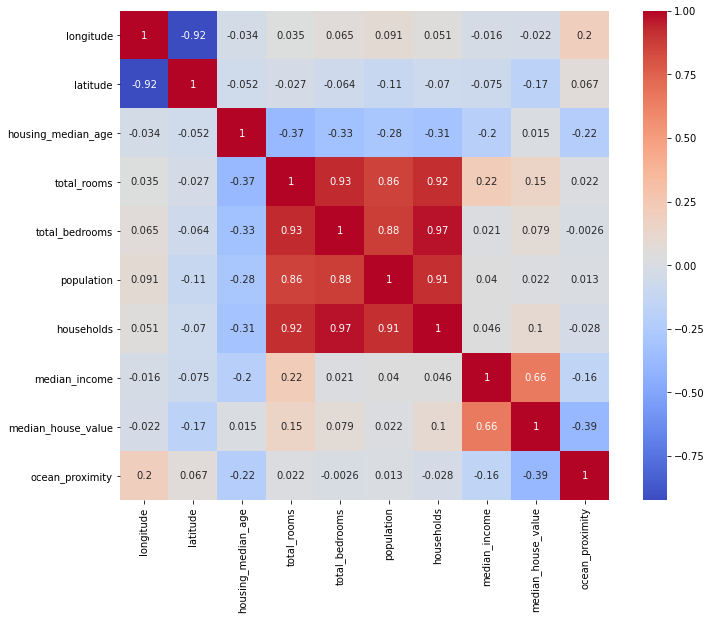

In [34]:
correlations = corr_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(correlations, square=True, annot=True, cmap= 'coolwarm')

In [35]:
correlations[((correlations>0.90) | (correlations<-0.90)) & (correlations != 1.0)].dropna(axis='index', how ='all')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
longitude,NaN,-0.922733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,-0.922733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_rooms,NaN,NaN,NaN,NaN,0.932133,NaN,0.921863,NaN,NaN,NaN
total_bedrooms,NaN,NaN,NaN,0.932133,NaN,NaN,0.973673,NaN,NaN,NaN
population,NaN,NaN,NaN,NaN,NaN,NaN,0.910622,NaN,NaN,NaN
households,NaN,NaN,NaN,0.921863,0.973673,0.910622,NaN,NaN,NaN,NaN


## Standardizing data

We extract from the dataset the column defining the house value *median_house_value* and we use it as the dependent variable *y*.

In [36]:
#n_corr_df = corr_df.copy()

In [37]:
corr_df.drop(columns = ['households'], inplace=True)

In [38]:
y = corr_df['median_house_value']

In [39]:
corr_df.drop(columns=['median_house_value'], inplace=True)

In [40]:
scaler = MinMaxScaler(feature_range=(-1,1))
X_scaled = scaler.fit_transform(corr_df)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [42]:
X_train.shape

(14856, 9)

In [43]:
X_scaled_df = pd.DataFrame(X_scaled, columns=corr_df.columns)

## RIDGE REGRESSION

We define the rigde regression starting from the following equation:
    
   $ w = (\alpha I+S^TS)^{-1} S^Ty$


In [44]:
def my_ridge(alpha, X, y):
    trans = X.T @ X
    I = np.identity(trans.shape[0])
    w = np.linalg.inv(alpha * I + trans) @ (X.T @ y)
    return w

In [45]:
w = my_ridge(1, X_train, y_train)

In [46]:
w

array([-168460.89999939, -161134.12030442,   16452.68532663,
       -144672.60919374,  213951.11043844, -553697.49594346,
        204518.25620271,  277796.39211614,   -9983.12013711])

In [47]:
y_hat = np.dot(X_test, w)

In [48]:
mean_squared_error(y_test, y_hat)

3557365313.360275

In [49]:
from sklearn.base import BaseEstimator

class MyRidge(BaseEstimator):
    def __init__(self, alpha=1):
        self.alpha = alpha
    
    def fit(self, X, y):
        trans = X.T @ X
        I = np.identity(trans.shape[0])
        self.w = np.linalg.inv(self.alpha * I + trans) @ (X.T @ y)
        
        return self


    def score(self, X, y):
        y_pred = self.predict(X)
        return mean_squared_error(y, y_pred)
    
    
    def predict(self, X):
        pred = np.dot(X, self.w)
        return pred

In [50]:
clf = MyRidge()
clf.fit(X_train, y_train)

MyRidge()

In [51]:
clf.score(X_train, y_train) # mean_squared_error

3602391107.8139987

In [52]:
y_pred = clf.predict(X_train) # S*w = v

In [53]:
#clf.

In [54]:
sizes = range(5000, 14856, 800)
learner = MyRidge()
train_size, train_score, val_score = learning_curve(learner, X_scaled, y, train_sizes=sizes, cv=5, scoring='neg_mean_squared_error')

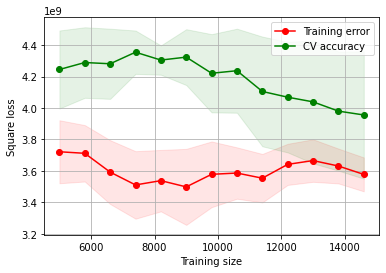

In [55]:
train_score_mean = -np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = -np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(sizes, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(sizes, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(sizes, train_score_mean, 'o-', color="r",
         label="Training error")
plt.plot(sizes, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Square loss')
plt.show()

The risk estimate is between 0.4 and 0.8, with small variance.

In [56]:
coef_list = []

for s in range(5000, 14856, 800):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=s, random_state=42)
    learner.fit(X_train, y_train)
    coef_list.append(learner.w)

coef_matrix = np.array(coef_list)

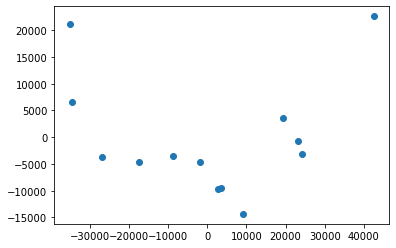

In [57]:
pca = decomposition.PCA(n_components=2)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

fig, ax = plt.subplots()
#ax.set_xlim(-1.5, 1.5)
#ax.set_ylim(-0.5, 0.5)
plt.scatter(coef_pca[:,0], coef_pca[:,1])

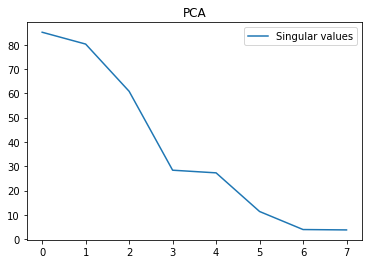

In [58]:
pca = decomposition.PCA(n_components=8)
pca.fit(X_scaled)

plt.title('PCA')
plt.plot(pca.singular_values_, label='Singular values')
plt.legend()
plt.show()

In [59]:
pca = decomposition.PCA(n_components=6)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [60]:
sizes = range(5000, 14856, 800)
train_size, train_score, val_score = learning_curve(learner, X_pca, y, train_sizes=sizes, cv=5, scoring='neg_mean_squared_error')

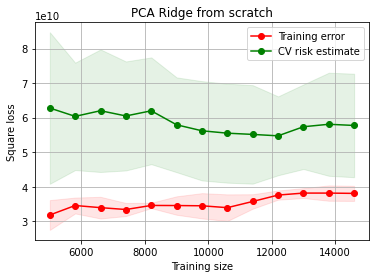

In [61]:
plt.title('PCA Ridge from scratch')
train_score_mean = -np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = -np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(sizes, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(sizes, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(sizes, train_score_mean, 'o-', color="r",
         label="Training error")
plt.plot(sizes, val_score_mean, 'o-', color="g",
         label="CV risk estimate")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Square loss')
plt.show()

The risk estimate is between 3 and 1.5, with big variance.

In [62]:
coef_list = []

for s in range(5000, 14856, 800):
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=s, random_state=42)
    learner.fit(X_train, y_train)
    coef_list.append(learner.w)
coef_matrix = np.array(coef_list)

pca = decomposition.PCA(n_components=2)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

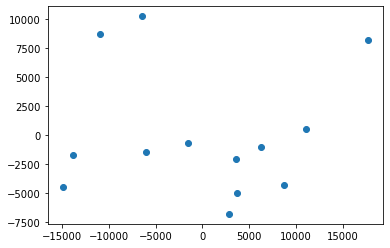

In [63]:
fig, ax = plt.subplots()
#ax.set_xlim(-1.5, 1.5)
#ax.set_ylim(-0.5, 0.5)
plt.scatter(coef_pca[:,0], coef_pca[:,1])

In [64]:
param_grid = [{'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}]

rdg = MyRidge()
grid = GridSearchCV(rdg, param_grid, cv = 5, verbose=10, n_jobs=-1)

grid.fit(X_train, y_train)

grid.best_params_, grid.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


({'alpha': 1e-05}, 39818728529.71279)

### Ridge with sklearn

In [65]:
rid = Ridge(alpha=1.0)
rid.fit(X_train, y_train)

Ridge()

In [66]:
rid.predict(X_test)

array([193101.43241512, 172456.98998645,  66249.48886348, ...,
       203230.01069388,   7811.4379685 , 318827.96204444])

In [67]:
mean_squared_error(y_test, rid.predict(X_test))

3882453518.5082464

In [68]:
# GET INSPIRED https://rstudio-pubs-static.s3.amazonaws.com/520912_bbd05dad7ffe4eb08ab51ee2c5bd90bb.html